In [1]:
import sys
print(sys.version)

CURR_DIR = '/content/drive/My Drive/google_colab_work/advanced_deep_learning_by_pytorch/'
CURR_DIR += '1_image_classification/'
sys.path.append(CURR_DIR)

3.6.9 (default, Apr 18 2020, 01:56:04) 
[GCC 8.4.0]


In [2]:
import glob
import os.path
import random
import numpy as np
import json
import PIL.Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
from torchvision import transforms
print('torch.__version__ =', torch.__version__)
print('torchvision.__version__ =', torchvision.__version__)

torch.__version__ = 1.5.1+cu101
torchvision.__version__ = 0.6.1+cu101


In [20]:
torch.cuda.is_available()

True

In [3]:
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [4]:
def MakeDatapathList(phase):
    root_path = CURR_DIR + 'data/hymenoptera_data/'
    target_path = os.path.join(root_path + phase + '/**/*.jpg')
    print('target_path =', target_path)

    datapath_list = []
    for datapath in glob.glob(target_path):
        datapath_list.append(datapath)

    return datapath_list

In [5]:
class ImageTransform():
    def __init__(self, resize, mean, stddev):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, stddev),
            ]),
            'val': transforms.Compose([
                transforms.Resize(resize),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, stddev),
            ]),
        } 
        

    def __call__(self, img, phase):
        return self.data_transform[phase](img)

In [6]:
class HymenopteraDataset(torch.utils.data.Dataset):
    def __init__(self, datapath_list, data_transform, phase):
        self.datapath_list = datapath_list
        self.data_transform = data_transform
        self.phase = phase


    def __len__(self):
        return len(self.datapath_list)


    def __getitem__(self, idx):
        img_path = self.datapath_list[idx]
        img = PIL.Image.open(img_path)
        img_transformed = self.data_transform(img, self.phase)

        label = img_path.split('/')[-2]
        assert label == 'ants' or label == 'bees'
        if label == 'ants':
            label = 0
        elif label == 'bees':
            label = 1

        return img_transformed, label

In [7]:
train_list = MakeDatapathList(phase='train')
val_list = MakeDatapathList(phase='val')

print()
print('len(train_list) =', len(train_list))
print('len(val_list) =', len(val_list))

target_path = /content/drive/My Drive/google_colab_work/advanced_deep_learning_by_pytorch/1_image_classification/data/hymenoptera_data/train/**/*.jpg
target_path = /content/drive/My Drive/google_colab_work/advanced_deep_learning_by_pytorch/1_image_classification/data/hymenoptera_data/val/**/*.jpg

len(train_list) = 243
len(val_list) = 153


In [8]:
resize = 224 # [px]
mean = (0.485, 0.456, 0.406)
stddev = (0.229, 0.224, 0.225)
data_transform = ImageTransform(resize, mean, stddev)

train_dataset = HymenopteraDataset(train_list, data_transform, phase='train')
val_dataset = HymenopteraDataset(val_list, data_transform, phase='val')

idx = 0
img_transformed, label = train_dataset.__getitem__(idx)
print('img_transformed.size() =', img_transformed.size())
print('label =', label)

img_transformed.size() = torch.Size([3, 224, 224])
label = 0


In [9]:
batch_size = 32

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=False)

print('len(train_dataloader.dataset) =', len(train_dataloader.dataset))
print('len(val_dataloader.dataset) =', len(val_dataloader.dataset))
print()

dataloaders_dict = {
    'train': train_dataloader,
    'val': val_dataloader,
}

len(train_dataloader.dataset) = 243
len(val_dataloader.dataset) = 153



In [10]:
batch_iter = iter(dataloaders_dict['train'])
inputs, labels = next(batch_iter)

print('inputs.size() =', inputs.size())
print()

print('labels.size() =', labels.size())
print('labels =', labels)

inputs.size() = torch.Size([32, 3, 224, 224])

labels.size() = torch.Size([32])
labels = tensor([1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1,
        0, 1, 0, 0, 0, 0, 0, 1])


In [11]:
net = torchvision.models.vgg16(pretrained=True)
net.classifier[6] = torch.nn.Linear(in_features=4096, out_features=2)
net.train()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [12]:
update_param_names_1 = ['features']
update_param_names_2 = ['classifier.0.weight', 'classifier.0.bias', 'classifier.3.weight', 'classifier.3.bias']
update_param_names_3 = ['classifier.6.weight', 'classifier.6.bias']

update_params_1 = []
update_params_2 = []
update_params_3 = []

for param_name, param in net.named_parameters():
    if update_param_names_1[0] in param_name:
        param.requires_grad = True
        update_params_1.append(param)
        print('Append to update_params_1: param_name =', param_name)
    elif param_name in update_param_names_2:
        param.requires_grad = True
        update_params_2.append(param)
        print('Append to update_params_2: param_name =', param_name)
    elif param_name in update_param_names_3:
        param.requires_grad = True
        update_params_3.append(param)
        print('Append to update_params_3: param_name =', param_name)
    else:
        param.requires_grad = False
        print()
        print('No fine tuning: param_name =', param_name)
        print()

Append to update_params_1: param_name = features.0.weight
Append to update_params_1: param_name = features.0.bias
Append to update_params_1: param_name = features.2.weight
Append to update_params_1: param_name = features.2.bias
Append to update_params_1: param_name = features.5.weight
Append to update_params_1: param_name = features.5.bias
Append to update_params_1: param_name = features.7.weight
Append to update_params_1: param_name = features.7.bias
Append to update_params_1: param_name = features.10.weight
Append to update_params_1: param_name = features.10.bias
Append to update_params_1: param_name = features.12.weight
Append to update_params_1: param_name = features.12.bias
Append to update_params_1: param_name = features.14.weight
Append to update_params_1: param_name = features.14.bias
Append to update_params_1: param_name = features.17.weight
Append to update_params_1: param_name = features.17.bias
Append to update_params_1: param_name = features.19.weight
Append to update_para

In [13]:
def TrainModel(net, dataloaders_dict, criterion, optimizer, num_epochs):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print('device =', device)
    print()

    net.to(device)
    torch.backends.cudnn.benchmark = True ### Make the inference processing faster

    for epoch in range(num_epochs):
        print('Epoch: ', epoch+1, '/', num_epochs)

        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()
            elif phase == 'val':
                net.eval()

            epoch_loss = 0.0
            epoch_num_correct = 0

            if epoch == 0 and phase == 'train':
                continue

            for inputs, labels in tqdm(dataloaders_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                is_grad_enabled = (phase == 'train')

                with torch.set_grad_enabled(is_grad_enabled):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)
                    _, pred_idxs = torch.max(outputs, dim=1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    epoch_loss += loss.item() * inputs.size()[0]
                    epoch_num_correct +=  torch.sum(pred_idxs == labels)

            num_dataset = len(dataloaders_dict[phase].dataset)
            epoch_loss = epoch_loss / num_dataset
            epoch_acc = epoch_num_correct.item() / num_dataset

            print()
            print()
            print(phase, ': epoch_loss =', round(epoch_loss,4), ', epoch_acc =', round(epoch_acc,4))
            print()

In [14]:
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(
    [
        { 'params': update_params_1, 'lr': 0.1e-3 },
        { 'params': update_params_2, 'lr': 0.5e-3 },
        { 'params': update_params_3, 'lr': 1.0e-3 },
    ],
    momentum=0.9
)

num_epochs = 3

TrainModel(net, dataloaders_dict, criterion, optimizer, num_epochs)

device = cuda:0



  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  1 / 3


  0%|          | 0/8 [00:00<?, ?it/s]



val : epoch_loss = 0.807 , epoch_acc = 0.3595

Epoch:  2 / 3


  0%|          | 0/5 [00:00<?, ?it/s]



train : epoch_loss = 0.4911 , epoch_acc = 0.7407



  0%|          | 0/8 [00:00<?, ?it/s]



val : epoch_loss = 0.1816 , epoch_acc = 0.9477

Epoch:  3 / 3


  0%|          | 0/5 [00:00<?, ?it/s]



train : epoch_loss = 0.1318 , epoch_acc = 0.9506



100%|██████████| 5/5 [00:02<00:00,  2.45it/s]



val : epoch_loss = 0.1224 , epoch_acc = 0.9673



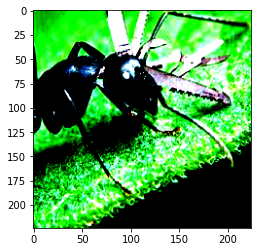

result = ants


In [18]:
img = PIL.Image.open(CURR_DIR+'data/hymenoptera_data/train/ants/swiss-army-ant.jpg')
img_transformed = data_transform(img, phase='train') ### torch.Size([3, 244, 244])

img_transformed_np = img_transformed.numpy().transpose((1, 2, 0)) ### (c, h, w) ---> (h, w, c)
img_transformed_np = np.clip(img_transformed_np, 0, 1)
plt.imshow(img_transformed_np)
plt.show()

inputs = img_transformed.view(1, *img_transformed.size()) ### torch.Size([1, 3, 244, 244])

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
inputs = inputs.to(device)
net.to(device)

outputs = net(inputs)

_, pred_idxs = torch.max(outputs, dim=1)
if pred_idxs == 0:
    result = 'ants'
elif pred_idxs == 1:
    result = 'bees'

print('result =', result)

In [19]:
### Save weights
path = CURR_DIR + 'weights_fine_tuning.pth'
torch.save(net.state_dict(), path)

### Load weights
load_weights = torch.load(path)
# load_weights = torch.load(path, map_location={ 'cuda:0': 'cpu' })
net.load_state_dict(load_weights)

<All keys matched successfully>